In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))


In [2]:
import sys
sys.path.append('/tf/home/DCTR_BachelorThesis')
import DCTR
import numpy as np
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from importlib import reload
reload(DCTR)


<module 'DCTR' from '/tf/home/DCTR_BachelorThesis/DCTR.py'>

# load and prep training data

In [3]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0

X0 = []
X1 = []

# MiNNLO
X1 = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/0001-0500_converted_lhe.npz'))
                     
print('MiNNLO all particles X1.shape: '+str(X1.shape))

# POWHEG hvq
X0 = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/seed1-seed5_converted_lhe.npz'))
print('POWHEG hvq all particles X0.shape: '+str(X0.shape))


MiNNLO all particles X1.shape: (4863968, 11, 9)
POWHEG hvq all particles X0.shape: (8607811, 11, 9)


In [4]:
X1b = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000_converted_lhe.npz'))

X1 = np.concatenate((X1, X1b))
print('MiNNLO all particles X1.shape: '+str(X1.shape))

MiNNLO all particles X1.shape: (9553938, 11, 9)


In [5]:
# removing all particles except the top and anti-top
# MiNNLO and POWHEG hvq gave different amounts of secondary particles -> too easy to tell apart

X0, X1 = DCTR.remove_jet_parts(X0, X1) # default: maxJetParts=0 -> only tt-pair, top and anti-top left in array


In [6]:
# truncate the arrays to the length of the shorter one, so that both arrays have the same number of events

X0, X1 = DCTR.trim_datasets(X0, X1)

print('MiNNLO all particles X1.shape: '+str(X1.shape))
print('POWHEG hvq all particles X0.shape: '+str(X0.shape))


MiNNLO all particles X1.shape: (8607811, 3, 9)
POWHEG hvq all particles X0.shape: (8607811, 3, 9)


In [7]:
# normalize arrays
'''
Here the values of the arrays are normalized to small floats, for better handling by the neural network
Rapidity and Phi values are already sufficiently small
'''
X0, X1, norm_dict = DCTR.normalize_data_2(X0, X1) # defaults: pt=True, rapidity=True,  phi=True, mass=True, PID=True, wgt=True, pseudorapidity=True, energy=True

print('arg : (mean, std, use_log)')
for k, v in norm_dict.items():
    print (k, ':', v)
    

arg : (mean, std, use_log)
pt : (4.220480384983634, 1.0144128980762428, True)
rapidity : (0.0, 1.238752036949656, False)
phi : (0.0, 3.141592653589793, False)
mass : (5.505494667639676, 0.5317358304220859, True)
pseudorapidity : (0.0, 1.9094622705583484, False)
energy : (6.151053553609387, 0.6480704371295263, True)


In [8]:
# prep arrays for the neural network
# Strips the theta parameter off the datasets and creates a one-hot classifier array Y
# Also strips the weights off the datasets and creates a weights array
# The Datasets are combined and returned shuffled (by default) 
# 15% (by default) are taken for the evaluation sets and the rest are used for the training
# returns: X_train, X_val, Y_train, Y_val, wgt_train, wgt_val

X_train, X_val, Y_train, Y_val, wgt_train, wgt_val = DCTR.prep_arrays(X0, X1, use_class_weights=False) # defaults: val=0.15, shuffle=True, use_class_weights=True

# clear previous temp arrays from memory
# X0 = []
# X1 = []



In [12]:
print(X_train[:5])
print(Y_train[:5])
print(wgt_train[:5])


[[[ 0.45956575  1.53122353  0.34702915  1.14699328  0.80191348
    1.87969662  0.        ]
  [-1.10905166  0.91966463  0.49766394 -0.68317473  0.4816354
   -0.70507873  0.6       ]
  [ 0.26867661  2.08487009  0.3110913  -0.67417005  1.09186242
    1.55970601 -0.6       ]]

 [[ 0.82944482 -0.90325731 -0.07115028  2.19411564 -0.47304276
    1.64773245  0.        ]
  [ 1.34473801 -1.20750218 -0.92845847 -0.66998273 -0.63237813
    0.70985475  0.6       ]
  [ 1.78038075 -0.68604241  0.01871996 -0.6494305  -0.35928566
    0.43420535 -0.6       ]]

 [[-2.4657394  -2.32102303 -0.48655284  0.79304734 -1.21553752
    3.02659215  0.        ]
  [ 0.19280757 -2.22980934 -0.76205145 -0.75887483 -1.16776821
    1.7543812   0.6       ]
  [ 0.1501737  -2.40993077  0.22087857 -0.68028412 -1.26209918
    2.13614003 -0.6       ]]

 [[-3.70897714  0.93789453  0.24458706  0.910642    0.49118254
    0.61838347  0.        ]
  [ 0.34603121  0.80449406 -0.64251616 -0.65303974  0.42131969
   -0.6587156   0.6   

# prep and train DCTR neural network

Starting training
Epoch 1/10
1778/1787 [============================>.] - ETA: 0s - loss: 24.1165 - acc: 0.5305
Epoch 1: val_loss improved from inf to 0.70672, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training.h5
1787/1787 [==============================] - 10s 5ms/step - loss: 24.0079 - acc: 0.5306 - val_loss: 0.7067 - val_acc: 0.5496 - lr: 0.0010
Epoch 2/10
1779/1787 [============================>.] - ETA: 0s - loss: 0.7042 - acc: 0.5530
Epoch 2: val_loss improved from 0.70672 to 0.70372, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training.h5
1787/1787 [==============================] - 9s 5ms/step - loss: 0.7042 - acc: 0.5530 - val_loss: 0.7037 - val_acc: 0.5526 - lr: 0.0010
Epoch 3/10
1780/1787 [============================>.] - ETA: 0s - loss: 0.6996 - acc: 0.5588
Epoch 3: val_loss improved from 0.70372 to 0.69815, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training.h5
1787/1787 [==============================] - 9s 5ms/step - l

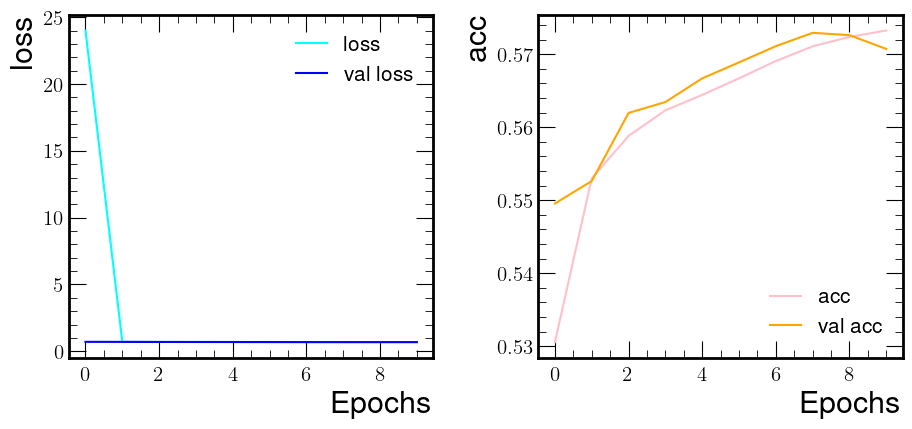

In [19]:
#initialize training
dctr, callbacks = DCTR.setup_nn(Phi_sizes = (10,10,12), F_sizes = (10,10,10))

dctr, callbacks = DCTR.setup_nn(patience=5, use_custom_loss=True, dropout=0)
DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, epochs=10, batch_size=8192)


Starting training
Epoch 1/500
445/447 [============================>.] - ETA: 0s - loss: 1034210.0000 - acc: 0.5018
Epoch 1: val_loss improved from inf to 0.71389, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d50.h5
447/447 [==============================] - 8s 15ms/step - loss: 1030617.0000 - acc: 0.5018 - val_loss: 0.7139 - val_acc: 0.5223 - lr: 0.0010
Epoch 2/500
444/447 [============================>.] - ETA: 0s - loss: 2070.8379 - acc: 0.5015
Epoch 2: val_loss improved from 0.71389 to 0.71379, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d50.h5
447/447 [==============================] - 6s 14ms/step - loss: 2061.7466 - acc: 0.5015 - val_loss: 0.7138 - val_acc: 0.5240 - lr: 0.0010
Epoch 3/500
445/447 [============================>.] - ETA: 0s - loss: 891.4910 - acc: 0.5011
Epoch 3: val_loss did not improve from 0.71379
447/447 [==============================] - 7s 15ms/step - loss: 893.3884 - acc: 0.5011 - val_loss: 0.7139 - val_acc: 

Epoch 30/500
445/447 [============================>.] - ETA: 0s - loss: 0.8799 - acc: 0.5001
Epoch 30: val_loss did not improve from 0.71379
447/447 [==============================] - 6s 14ms/step - loss: 0.8797 - acc: 0.5001 - val_loss: 0.7154 - val_acc: 0.5076 - lr: 7.4826e-04
Epoch 31/500
445/447 [============================>.] - ETA: 0s - loss: 0.9525 - acc: 0.5000
Epoch 31: val_loss did not improve from 0.71379
447/447 [==============================] - 6s 14ms/step - loss: 0.9516 - acc: 0.5000 - val_loss: 0.7155 - val_acc: 0.5066 - lr: 7.3345e-04
Epoch 32/500
445/447 [============================>.] - ETA: 0s - loss: 0.8857 - acc: 0.4999
Epoch 32: val_loss did not improve from 0.71379
447/447 [==============================] - 6s 14ms/step - loss: 0.8855 - acc: 0.4999 - val_loss: 0.7155 - val_acc: 0.5069 - lr: 7.1892e-04
Epoch 33/500
445/447 [============================>.] - ETA: 0s - loss: 0.8037 - acc: 0.5000
Epoch 33: val_loss did not improve from 0.71379
447/447 [==========

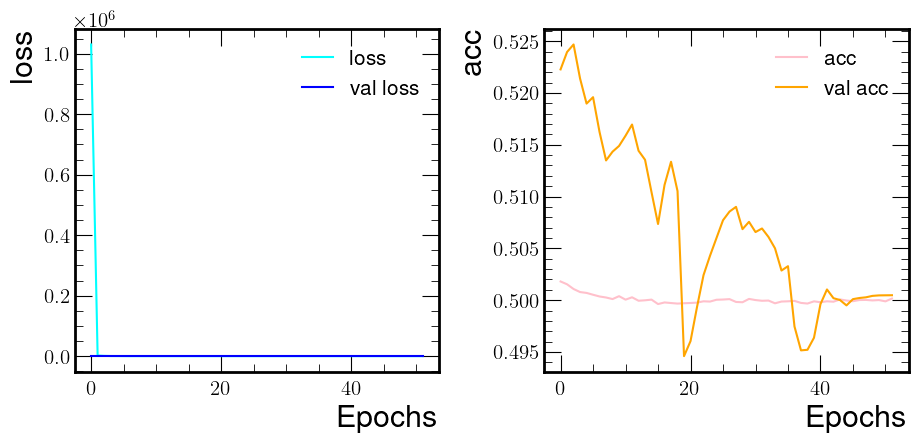

In [20]:
# training weights are enabled
# 50% Dropout
dctr, callbacks = DCTR.setup_nn(patience=50, use_custom_loss=True, dropout=0.5, saveLabel='DCTR_training_d50')
dctr.load_weights('DCTR_training.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, epochs=500, batch_size=8192*4, wgt_train=wgt_train, saveLabel='DCTR_training_d50')


Starting training
Epoch 1/500
444/447 [============================>.] - ETA: 0s - loss: 0.6521 - acc: 0.5174
Epoch 1: val_loss improved from inf to 0.70551, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d30.h5
447/447 [==============================] - 8s 15ms/step - loss: 0.6520 - acc: 0.5176 - val_loss: 0.7055 - val_acc: 0.5638 - lr: 0.0010
Epoch 2/500
444/447 [============================>.] - ETA: 0s - loss: 0.6330 - acc: 0.5535
Epoch 2: val_loss improved from 0.70551 to 0.70223, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d30.h5
447/447 [==============================] - 6s 14ms/step - loss: 0.6329 - acc: 0.5536 - val_loss: 0.7022 - val_acc: 0.5673 - lr: 0.0010
Epoch 3/500
443/447 [============================>.] - ETA: 0s - loss: 0.6288 - acc: 0.5625
Epoch 3: val_loss improved from 0.70223 to 0.70010, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d30.h5
447/447 [==============================] - 6s 14ms/step 

Epoch 25/500
446/447 [============================>.] - ETA: 0s - loss: 0.6111 - acc: 0.5772
Epoch 25: val_loss improved from 0.68058 to 0.68002, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d30.h5
447/447 [==============================] - 6s 14ms/step - loss: 0.6111 - acc: 0.5772 - val_loss: 0.6800 - val_acc: 0.5782 - lr: 8.2696e-04
Epoch 26/500
445/447 [============================>.] - ETA: 0s - loss: 0.6110 - acc: 0.5773
Epoch 26: val_loss did not improve from 0.68002
447/447 [==============================] - 6s 14ms/step - loss: 0.6110 - acc: 0.5773 - val_loss: 0.6806 - val_acc: 0.5779 - lr: 8.1058e-04
Epoch 27/500
445/447 [============================>.] - ETA: 0s - loss: 0.6110 - acc: 0.5773
Epoch 27: val_loss improved from 0.68002 to 0.68001, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d30.h5
447/447 [==============================] - 6s 14ms/step - loss: 0.6110 - acc: 0.5773 - val_loss: 0.6800 - val_acc: 0.5783 - lr: 7.9453e-0

Epoch 53/500
446/447 [============================>.] - ETA: 0s - loss: 0.6103 - acc: 0.5782
Epoch 53: val_loss did not improve from 0.67973
447/447 [==============================] - 6s 14ms/step - loss: 0.6103 - acc: 0.5782 - val_loss: 0.6799 - val_acc: 0.5788 - lr: 4.7237e-04
Epoch 54/500
445/447 [============================>.] - ETA: 0s - loss: 0.6103 - acc: 0.5783
Epoch 54: val_loss did not improve from 0.67973
447/447 [==============================] - 6s 14ms/step - loss: 0.6103 - acc: 0.5783 - val_loss: 0.6804 - val_acc: 0.5781 - lr: 4.6301e-04
Epoch 55/500
445/447 [============================>.] - ETA: 0s - loss: 0.6103 - acc: 0.5782
Epoch 55: val_loss did not improve from 0.67973
447/447 [==============================] - 6s 14ms/step - loss: 0.6103 - acc: 0.5782 - val_loss: 0.6797 - val_acc: 0.5783 - lr: 4.5384e-04
Epoch 56/500
444/447 [============================>.] - ETA: 0s - loss: 0.6102 - acc: 0.5783
Epoch 56: val_loss improved from 0.67973 to 0.67963, saving model t

Epoch 110/500
443/447 [============================>.] - ETA: 0s - loss: 0.6098 - acc: 0.5788
Epoch 110: val_loss did not improve from 0.67941
447/447 [==============================] - 6s 14ms/step - loss: 0.6098 - acc: 0.5789 - val_loss: 0.6797 - val_acc: 0.5789 - lr: 1.5107e-04
Epoch 111/500
443/447 [============================>.] - ETA: 0s - loss: 0.6099 - acc: 0.5788
Epoch 111: val_loss did not improve from 0.67941
447/447 [==============================] - 6s 14ms/step - loss: 0.6098 - acc: 0.5788 - val_loss: 0.6796 - val_acc: 0.5788 - lr: 1.4808e-04
Epoch 112/500
444/447 [============================>.] - ETA: 0s - loss: 0.6098 - acc: 0.5787
Epoch 112: val_loss did not improve from 0.67941
447/447 [==============================] - 6s 14ms/step - loss: 0.6098 - acc: 0.5787 - val_loss: 0.6795 - val_acc: 0.5789 - lr: 1.4515e-04
Epoch 113/500
443/447 [============================>.] - ETA: 0s - loss: 0.6098 - acc: 0.5788
Epoch 113: val_loss did not improve from 0.67941
447/447 [==

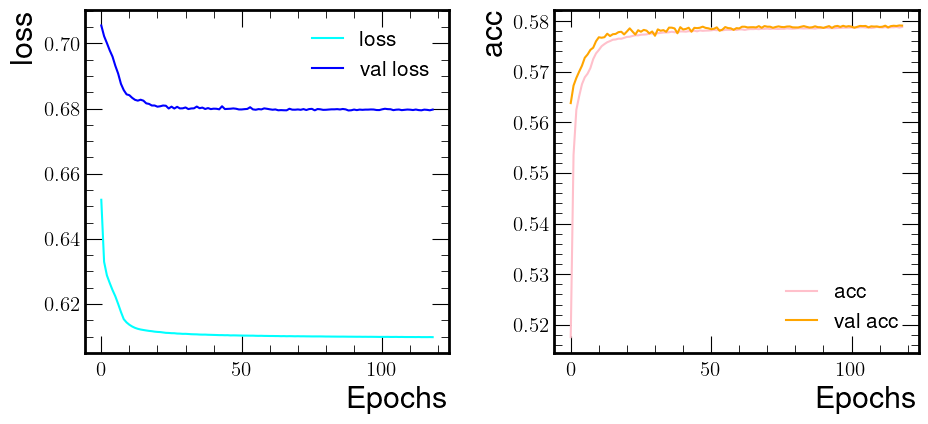

In [21]:
# training weights are enabled
# 30% Dropout
dctr, callbacks = DCTR.setup_nn(patience=30, use_custom_loss=True, dropout=0.3, saveLabel='DCTR_training_d30')
dctr.load_weights('DCTR_training_d50.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, epochs=500, batch_size=8192*4, wgt_train=wgt_train, saveLabel='DCTR_training_d30')


Starting training
Epoch 1/500
445/447 [============================>.] - ETA: 0s - loss: 0.6520 - acc: 0.5170
Epoch 1: val_loss improved from inf to 0.70485, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d20.h5
447/447 [==============================] - 8s 14ms/step - loss: 0.6519 - acc: 0.5171 - val_loss: 0.7049 - val_acc: 0.5640 - lr: 0.0010
Epoch 2/500
445/447 [============================>.] - ETA: 0s - loss: 0.6405 - acc: 0.5440
Epoch 2: val_loss did not improve from 0.70485
447/447 [==============================] - 6s 14ms/step - loss: 0.6405 - acc: 0.5440 - val_loss: 0.7050 - val_acc: 0.5622 - lr: 0.0010
Epoch 3/500
445/447 [============================>.] - ETA: 0s - loss: 0.6325 - acc: 0.5563
Epoch 3: val_loss improved from 0.70485 to 0.70247, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d20.h5
447/447 [==============================] - 6s 14ms/step - loss: 0.6325 - acc: 0.5564 - val_loss: 0.7025 - val_acc: 0.5653 - lr: 0.0010
Ep

Epoch 25/500
445/447 [============================>.] - ETA: 0s - loss: 0.6114 - acc: 0.5767
Epoch 25: val_loss improved from 0.68049 to 0.68024, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d20.h5
447/447 [==============================] - 6s 14ms/step - loss: 0.6114 - acc: 0.5766 - val_loss: 0.6802 - val_acc: 0.5775 - lr: 8.2696e-04
Epoch 26/500
446/447 [============================>.] - ETA: 0s - loss: 0.6113 - acc: 0.5767
Epoch 26: val_loss did not improve from 0.68024
447/447 [==============================] - 6s 14ms/step - loss: 0.6113 - acc: 0.5767 - val_loss: 0.6803 - val_acc: 0.5778 - lr: 8.1058e-04
Epoch 27/500
445/447 [============================>.] - ETA: 0s - loss: 0.6113 - acc: 0.5768
Epoch 27: val_loss did not improve from 0.68024
447/447 [==============================] - 6s 15ms/step - loss: 0.6113 - acc: 0.5768 - val_loss: 0.6803 - val_acc: 0.5780 - lr: 7.9453e-04
Epoch 28/500
445/447 [============================>.] - ETA: 0s - loss: 0.6112 

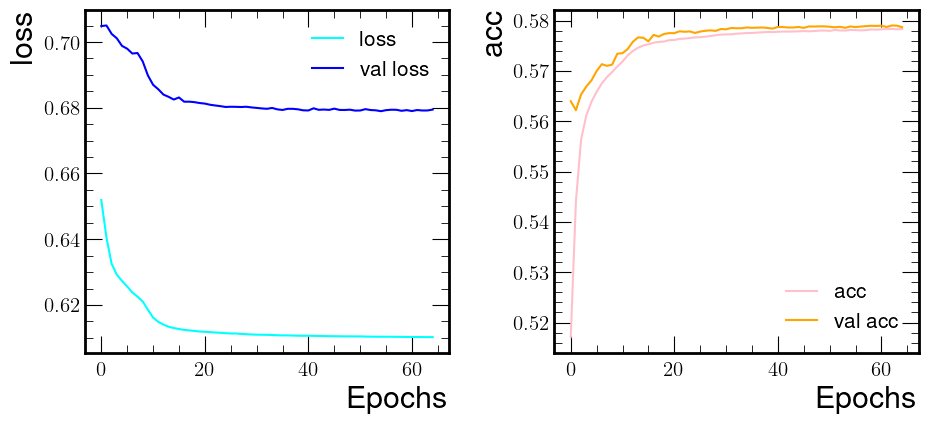

In [22]:
# training weights are enabled
# 20% Dropout
dctr, callbacks = DCTR.setup_nn(patience=10, use_custom_loss=True, dropout=0.3, saveLabel='DCTR_training_d20')
dctr.load_weights('DCTR_training_d50.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, epochs=500, batch_size=8192*4, wgt_train=wgt_train, saveLabel='DCTR_training_d20')


Starting training
Epoch 1/500
445/447 [============================>.] - ETA: 0s - loss: 0.6096 - acc: 0.5785
Epoch 1: val_loss improved from inf to 0.67852, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d05.h5
447/447 [==============================] - 8s 15ms/step - loss: 0.6096 - acc: 0.5785 - val_loss: 0.6785 - val_acc: 0.5786 - lr: 0.0010
Epoch 2/500
445/447 [============================>.] - ETA: 0s - loss: 0.6096 - acc: 0.5786
Epoch 2: val_loss improved from 0.67852 to 0.67830, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d05.h5
447/447 [==============================] - 6s 14ms/step - loss: 0.6096 - acc: 0.5786 - val_loss: 0.6783 - val_acc: 0.5787 - lr: 0.0010
Epoch 3/500
445/447 [============================>.] - ETA: 0s - loss: 0.6095 - acc: 0.5786
Epoch 3: val_loss did not improve from 0.67830
447/447 [==============================] - 6s 14ms/step - loss: 0.6095 - acc: 0.5786 - val_loss: 0.6783 - val_acc: 0.5788 - lr: 0.0010
Ep

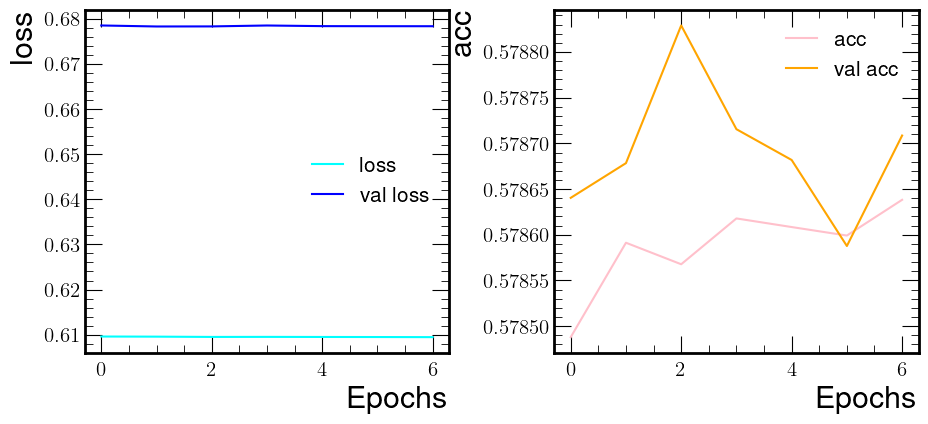

In [23]:
# training weights are enabled
# 5% Dropout
dctr, callbacks = DCTR.setup_nn(patience=5, use_custom_loss=True, dropout=0.05, saveLabel='DCTR_training_d05')
dctr.load_weights('DCTR_training_d20.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, epochs=500, batch_size=8192*4, wgt_train=wgt_train, saveLabel='DCTR_training_d05')


Starting training
Epoch 1/500
446/447 [============================>.] - ETA: 0s - loss: 0.6094 - acc: 0.5787
Epoch 1: val_loss improved from inf to 0.67842, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d00.h5
447/447 [==============================] - 7s 13ms/step - loss: 0.6094 - acc: 0.5787 - val_loss: 0.6784 - val_acc: 0.5787 - lr: 0.0010
Epoch 2/500
445/447 [============================>.] - ETA: 0s - loss: 0.6094 - acc: 0.5787
Epoch 2: val_loss improved from 0.67842 to 0.67820, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d00.h5
447/447 [==============================] - 5s 12ms/step - loss: 0.6093 - acc: 0.5787 - val_loss: 0.6782 - val_acc: 0.5790 - lr: 0.0010
Epoch 3/500
446/447 [============================>.] - ETA: 0s - loss: 0.6093 - acc: 0.5787
Epoch 3: val_loss improved from 0.67820 to 0.67818, saving model to /tf/home/DCTR_BachelorThesis/Notebooks/DCTR_training_d00.h5
447/447 [==============================] - 5s 12ms/step 

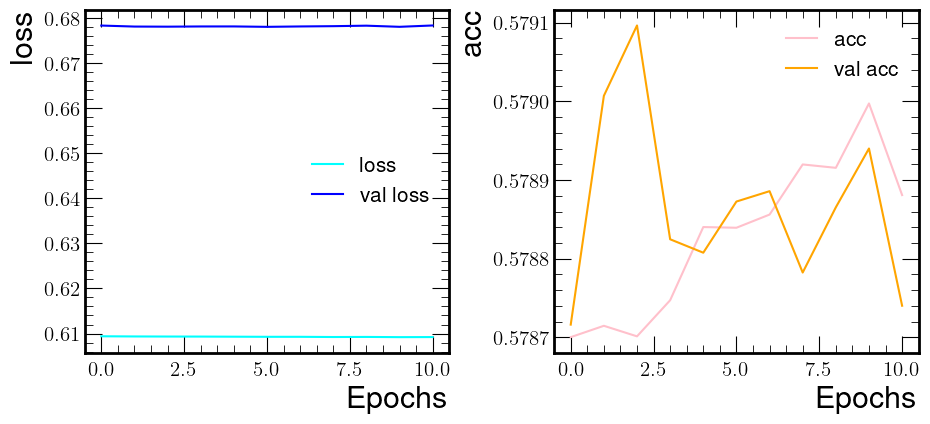

In [24]:
# training weights are enabled
# 0% Dropout
dctr, callbacks = DCTR.setup_nn(patience=5, use_custom_loss=True, saveLabel='DCTR_training_d00')
dctr.load_weights('DCTR_training_d05.h5')

DCTR.train(dctr, callbacks, X_train, Y_train, X_val, Y_val, epochs=500, batch_size=8192*4, wgt_train=wgt_train, saveLabel='DCTR_training_d00')


# load testing datasets

In [ ]:
# different datasets then the trainig ones

In [4]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0
# all particles arrays
X0_test = []
X1_test = []
# MiNNLO
X1_test = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000_converted_lhe.npz'))
# POWHEG hvq
X0_test = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/seed6-seed10_converted_lhe.npz'))


print('MiNNLO     X1_test.shape: '+str(X1_test.shape))
print('POWHEG hvq X0_test.shape: '+str(X0_test.shape))


MiNNLO     X1_test.shape: (4689970, 11, 9)
POWHEG hvq X0_test.shape: (8999487, 11, 9)


In [5]:
# removing all particles except the top and anti-top because that how dctr was trained
X0_test, X1_test = DCTR.remove_jet_parts(X0_test, X1_test) # default: maxJetParts=0 -> only tt-pair left in array


In [6]:
# normalize arrays because thats how dctr was trained, notr necessary with tt-pair_array, b/c dctr was only trained on all-particles_array
X0_nrm, X1_nrm, norm_dict = DCTR.normalize_data_2(X0_test, X1_test) # args: X, Y, pt=True, rapidity=True,  phi=True, mass=True, PID=True, wgt=True, pseudorapidity=True, energy=True


In [7]:
print('arg : (mean, std)')
for k, v in norm_dict.items():
    print (k, ':', v)
    

arg : (mean, std)
pt : (4.244270952562493, 0.9908358050201895, True)
rapidity : (0.0, 1.237915271312979, False)
phi : (0.0, 3.141592653589793, False)
mass : (5.505355575127179, 0.5324355467206314, True)
pseudorapidity : (0.0, 1.9027742619560484, False)
energy : (6.152905816965658, 0.6486844631153527, True)


In [8]:
# removing theta
X0_nrm = np.delete(X0_nrm, -1, -1) # theta paramater is last argument in last axis
X1_nrm = np.delete(X1_nrm, -1, -1)


In [9]:
# get gen weights from test datasets (normalized, two cells before)
X0_nrm_wgt = X0_nrm[:,0,5]
X1_nrm_wgt = X1_nrm[:,0,5]

# removing weight from test dataset
X0_nrm = np.delete(X0_nrm, -1, -1) # wgt paramater is last argument in last axis after removing theta
X1_nrm = np.delete(X1_nrm, -1, -1)


In [10]:
# Load Datasets: MiNNLO: X1 | POWHEG hvq: X0
# all particles arrays
X0_test = []
X1_test = []
# MiNNLO
X1_test = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000_converted_lhe.npz'))
# POWHEG hvq
X0_test = np.array(DCTR.load_dataset('/tf/data/BachelorThesis_Data/LHE/data/POWHEG_hvq/seed6-seed10_converted_lhe.npz'))

# load training and predict weights

In [11]:
# load training
dctr, callbacks = DCTR.setup_nn()
dctr.load_weights('DCTR_training_d20.h5')

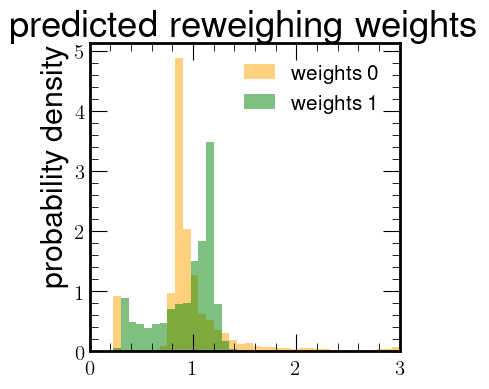

In [12]:
#plot weights
weights_0, weights_1 = DCTR.predict_weights(dctr, X0_nrm, X1_nrm)

DCTR.plot_weights(weights_0, weights_1, start=0, stop=3, div=41)


In [13]:
clip=0.001

predics_0 = np.clip(dctr.predict(X0_nrm, batch_size=8192), 0+clip, 1-clip)
predics_1 = np.clip(dctr.predict(X1_nrm, batch_size=8192), 0+clip, 1-clip)

# weights_0 = predics_0[:,1]/(1-predics_0[:,1])
# weights_1 = predics_1[:,0]/(1-predics_1[:,0])

print(predics_0[:5])
print(predics_1[:5])
print(weights_0[:5])
print(weights_1[:5])

[[0.5427439  0.4572561 ]
 [0.5291864  0.47081354]
 [0.5622233  0.43777668]
 [0.4836095  0.5163905 ]
 [0.5333699  0.4666301 ]]
[[0.5159428  0.48405722]
 [0.47752103 0.522479  ]
 [0.5101683  0.48983172]
 [0.33457485 0.6654252 ]
 [0.45860517 0.5413948 ]]
[0.8424896  0.8896931  0.77865267 1.0677841  0.87487143]
[1.0658716 0.9139527 1.0415176 0.5027986 0.8470808]


# check and plot DCTR predictions

In [ ]:
# tt-pair

8954772out of 8999487 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


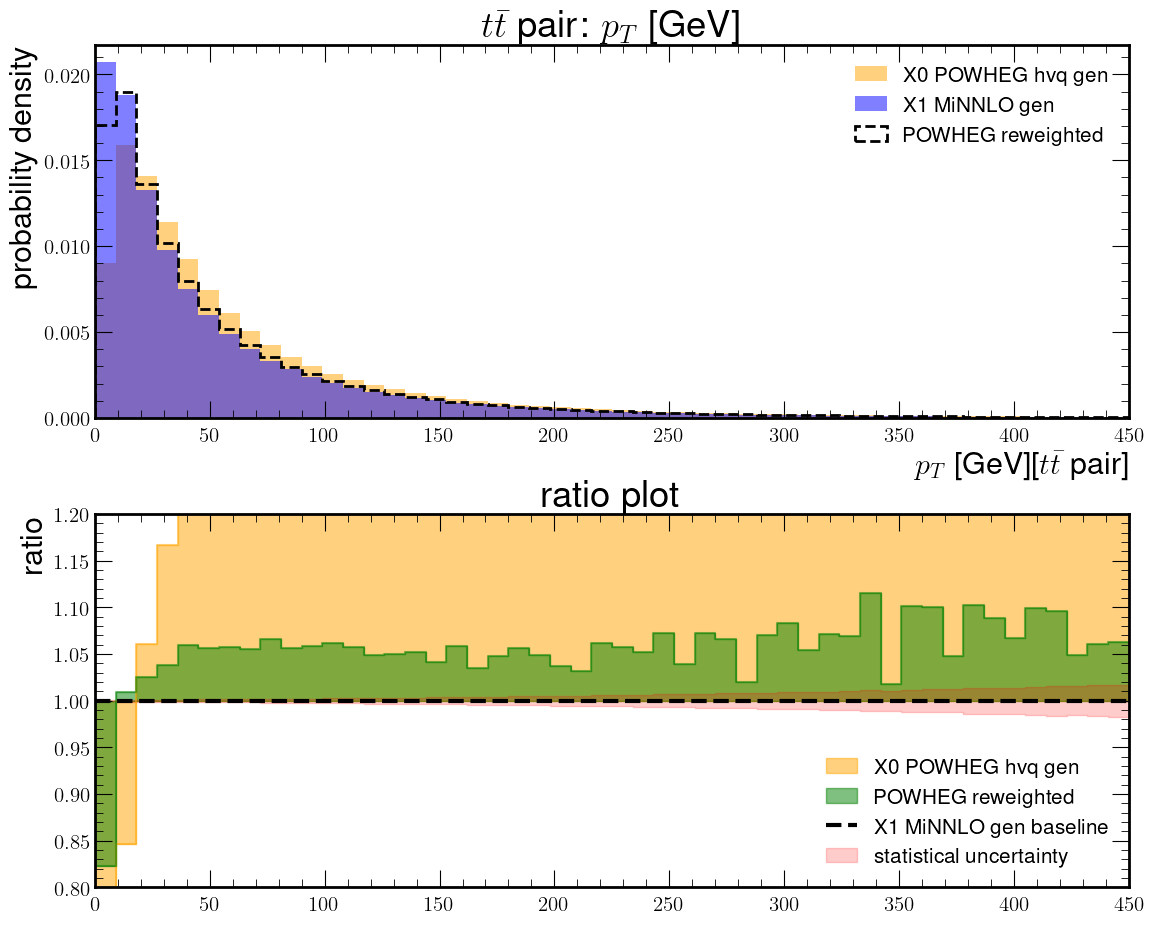

In [16]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, start=0, stop=450, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=X0_nrm_wgt*np.array(weights_0), ratio_ylim=[0.8,1.2])

8892797out of 8999487 events (98.81%) are between mass [GeV] 300 and 1200


/tf/home/DCTR_BachelorThesis/DCTR.py:801: RuntimeWarning: divide by zero encountered in true_divide
  ax2.step(bins, (n0/n1), alpha=0.5, color='orange', where='post')
/tf/home/DCTR_BachelorThesis/DCTR.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(bins, n0/n1, 1, label = X0_label, alpha=0.5, color='orange', step='post')
/tf/home/DCTR_BachelorThesis/DCTR.py:804: RuntimeWarning: divide by zero encountered in true_divide
  ax2.step(bins, (n2/n1), alpha=0.5, color='green', where='post')
/tf/home/DCTR_BachelorThesis/DCTR.py:805: RuntimeWarning: divide by zero encountered in true_divide
  ax2.fill_between(bins, n2/n1, 1, label = X2_label, alpha=0.5, color='green', step='post')


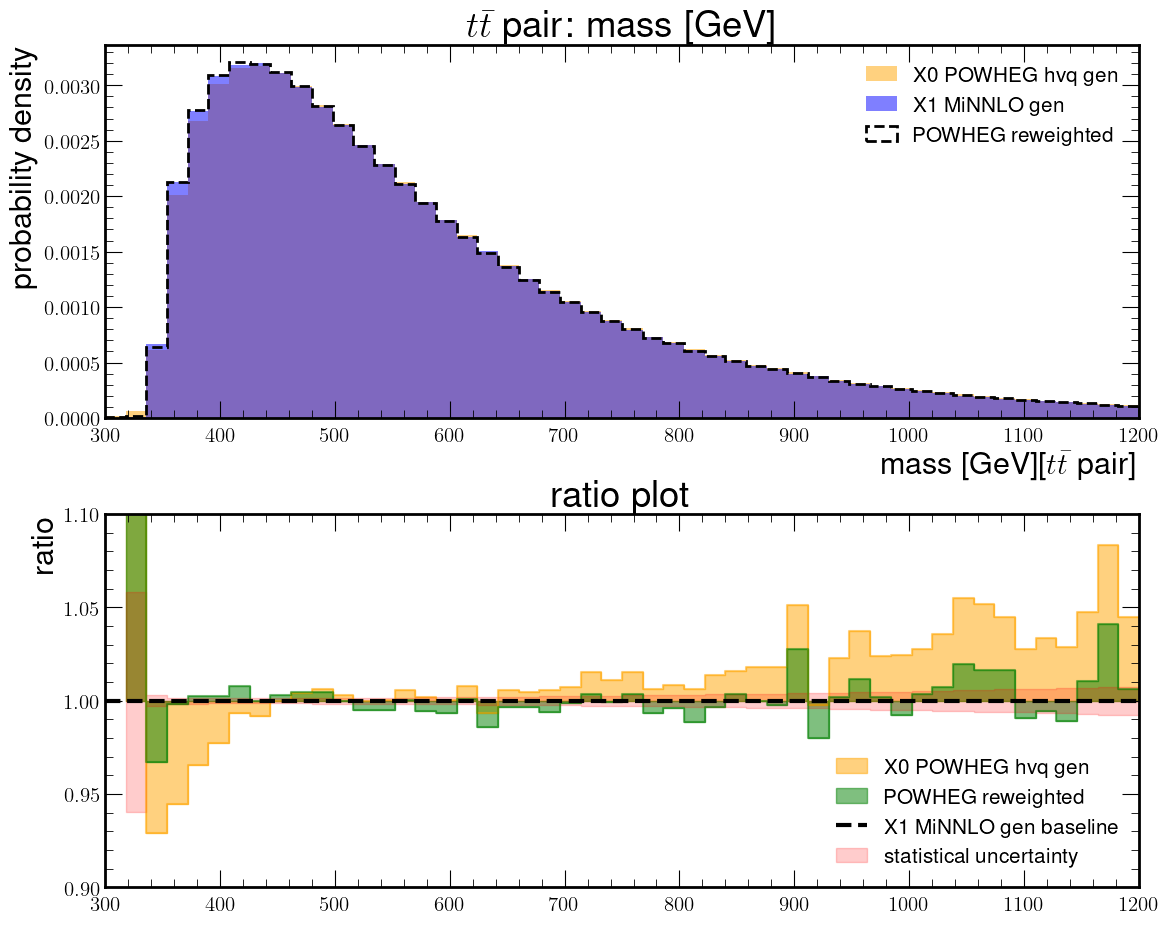

In [17]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, start=300, stop=1200, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=X0_nrm_wgt*np.array(weights_0))


In [18]:
# top quark

8954772out of 8999487 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


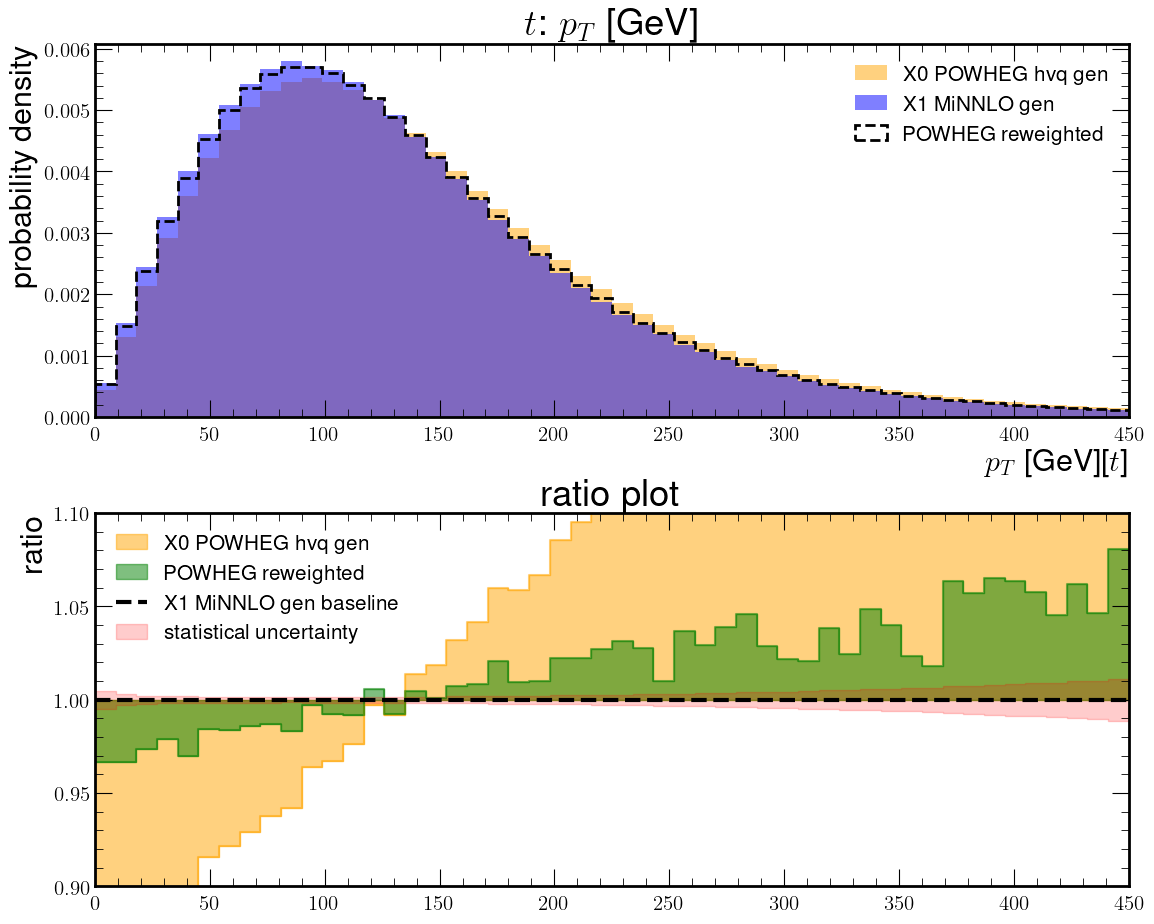

In [19]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, part_index = 1, start=0, stop=450, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=X0_nrm_wgt*np.array(weights_0))

0out of 8999487 events (0.0%) are between mass [GeV] 160 and 180


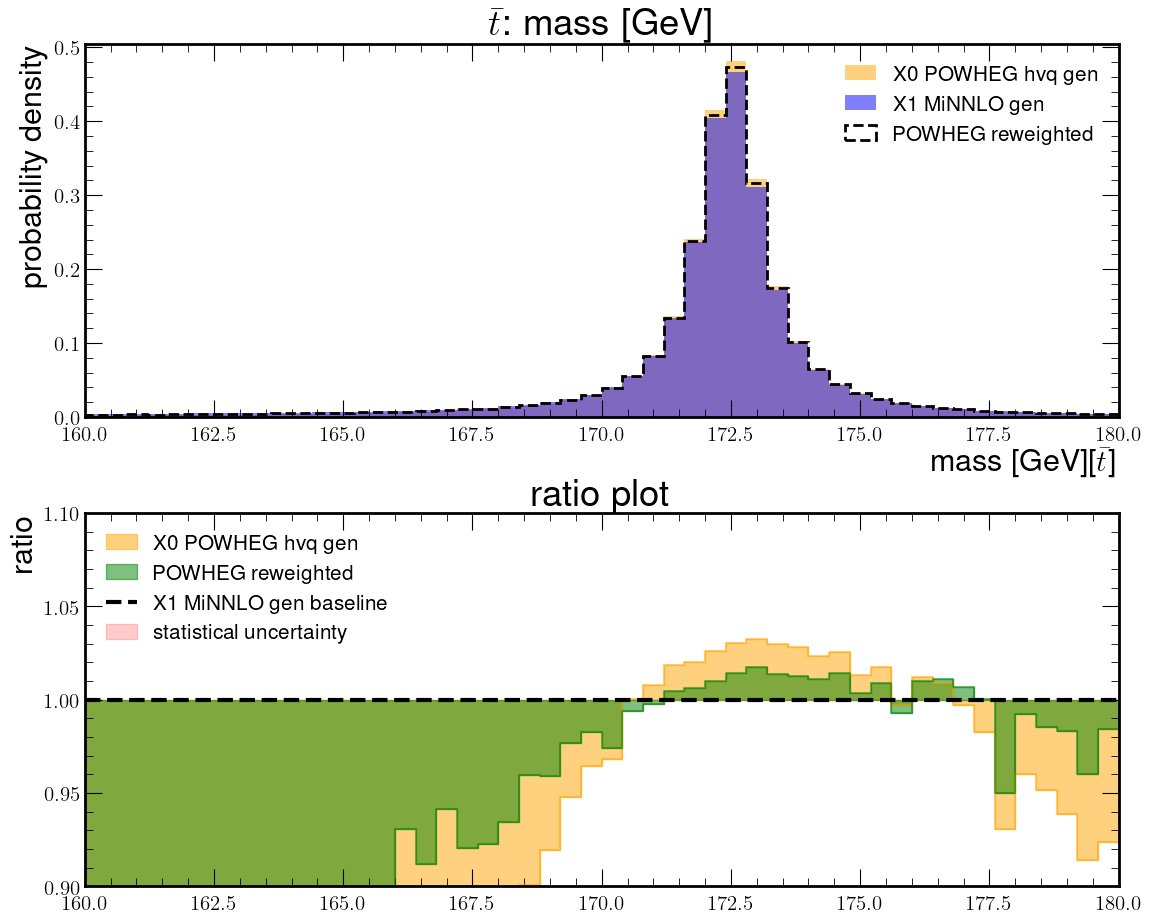

In [20]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, part_index = 2, start=160, stop=180, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=X0_nrm_wgt*np.array(weights_0))


In [21]:
# anti-top

8954772out of 8999487 events (99.5%) are between $p_{T}$ [GeV] 0 and 450


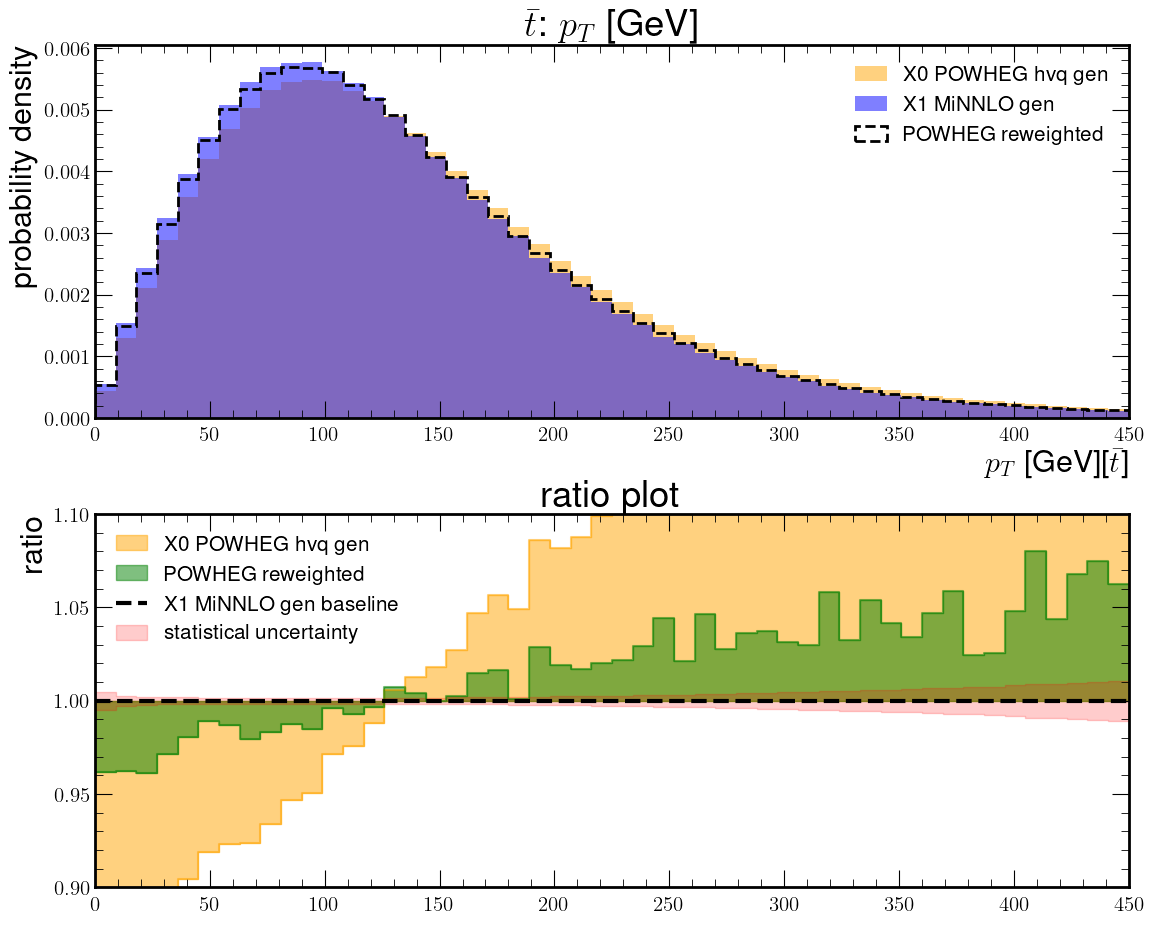

In [22]:
# pt
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 0, part_index = 2, start=0, stop=450, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=X0_nrm_wgt*np.array(weights_0))

0out of 8999487 events (0.0%) are between mass [GeV] 160 and 180


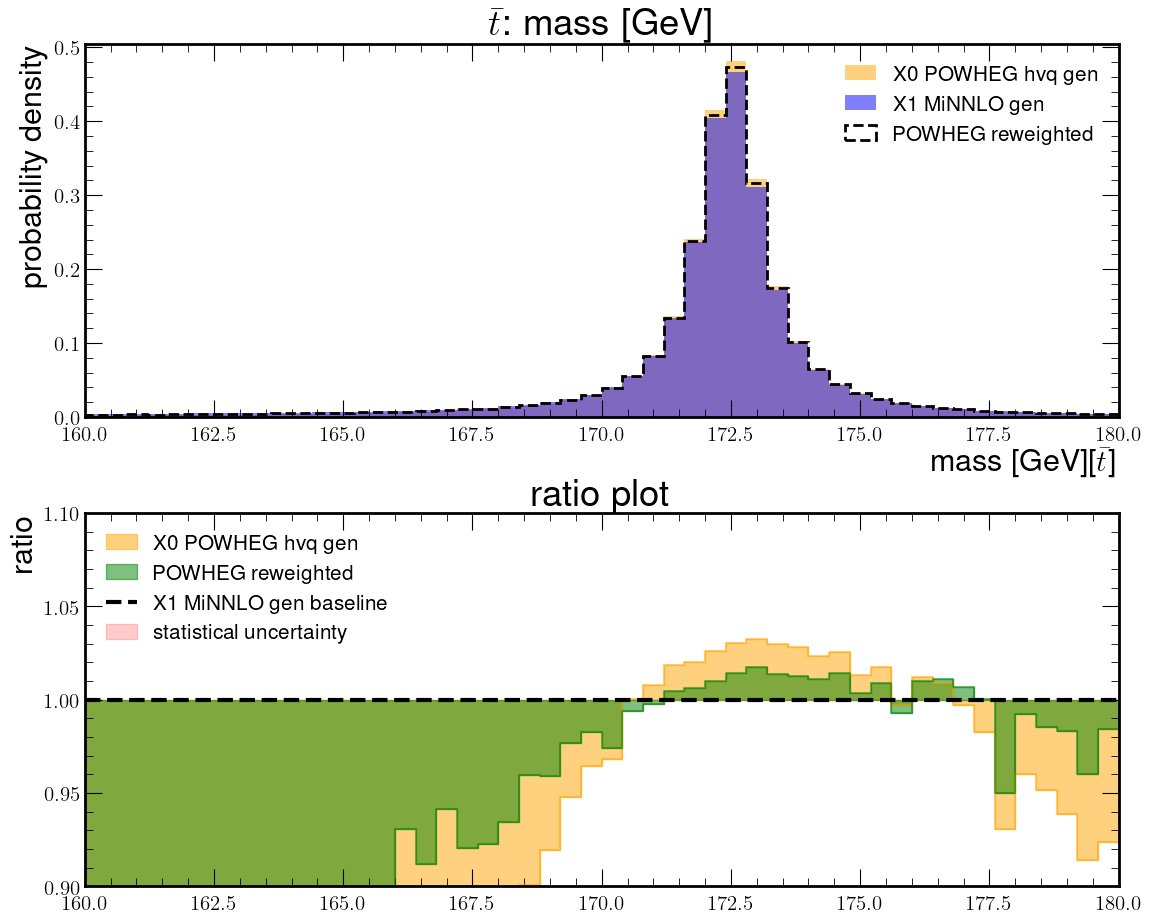

In [23]:
# mass
DCTR.plot_3_ratio(X0_test, X1_test, X0_test, arg_index = 3, part_index = 2, start=160, stop=180, div = 51, X0_wgt = X0_nrm_wgt, X1_wgt = X1_nrm_wgt, X2_wgt=X0_nrm_wgt*np.array(weights_0))
